In [1]:
import pickle
import numpy as np

mydir = "/home/anton/Documents/Tulane/Research/PNC_Good"
files = ["PNC_SPM_rest_good_filt.pkl", "PNC_SPM_nback_good_filt.pkl", "PNC_SPM_emoid_good_filt.pkl"]
ts = []

for i in range(1,2):
    pkl = mydir + '/' + files[i]
    f = pickle.load(open(pkl, 'rb'))
    for sub in f:
        ts.append(f[sub])

ts = np.stack(ts)
print(ts.shape)

(1456, 264, 231)


In [5]:
#https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, mid_channels, kernel_size=5, padding=2, bias=False).float().cuda(),
            nn.BatchNorm1d(mid_channels).float().cuda(),
            nn.ReLU(inplace=True),
            nn.Conv1d(mid_channels, out_channels, kernel_size=5, padding=2, bias=False).float().cuda(),
            nn.BatchNorm1d(out_channels).float().cuda(),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool1d(2).float().cuda(),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='linear', align_corners=True).float().cuda()
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose1d(in_channels, in_channels, kernel_size=2, stride=2).float().cuda()
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1):
        x1 = self.up(x1)
        # input is CHW
        #diffY = x2.size()[2] - x1.size()[2]
        #diffX = x2.size()[3] - x1.size()[3]

        #x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
        #                diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        #x = torch.cat([x2, x1], dim=1)
        return self.conv(x1)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1).float().cuda()

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64))
        self.down2 = (Down(64, 64))
        self.down3 = (Down(64, 128))
        factor = 2 if bilinear else 1
        self.down4 = (Down(128, 128 // factor))
        self.down5 = (Down(128, 128))
        self.down6 = (Down(128, 256))
        self.up1 = (Up(256, 128 // factor, bilinear))
        self.up2 = (Up(128, 128 // factor, bilinear))
        self.up3 = (Up(128, 128 // factor, bilinear))
        self.up4 = (Up(128, 128, bilinear))
        self.up5 = (Up(128, 64, bilinear))
        self.up6 = (Up(64, 32, bilinear))
        self.outc = (OutConv(32, n_classes))

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.down4(x)
        x = self.down5(x)
        z = self.down6(x)
        x = self.up1(z)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = self.up5(x)
        x = self.up6(x)
        x = self.outc(x)
        return x, z

def zloss(z):
    z = z.squeeze()
    mu = torch.mean(z, dim=0)
    zc = z - torch.mean(z, dim=0, keepdims=True)
    zc = zc.squeeze()
    C = zc.T@zc
    mu_loss = torch.mean(mu**2)
    C_loss = torch.mean((C-mu.shape[0]*torch.eye(mu.shape[0]).float().cuda())**2)
    return mu_loss, C_loss

ae = UNet(264, 264, bilinear=False)
optim = torch.optim.Adam(ae.parameters(), lr=5e-4, weight_decay=0)

nepochs = 5000
pperiod = 50

def pretty(x):
    return f'{round(float(x), 4)}'

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

x = torch.from_numpy(ts[:,:,10:74]).float().cuda()

for e in range(nepochs):
    optim.zero_grad()
    xhat, z = ae(x)
    loss = rmse(xhat, x)
    mu_loss, C_loss = zloss(z)
    (loss+mu_loss+C_loss).backward()
    optim.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(loss)} {pretty(mu_loss)} {pretty(C_loss)}')

print('Done')

0 6.6835 0.0752 67929.1562
50 6.5835 0.0349 182.1789
100 6.196 0.0443 144.8168
150 5.8959 0.0511 117.9775
200 5.719 0.0567 96.8045
250 5.6156 0.0612 79.8064
300 5.5546 0.0647 66.1219
350 5.5159 0.0676 54.9179
400 5.4797 0.0699 45.6841
450 5.433 0.0718 38.0586
500 5.3901 0.0731 31.6709
550 5.3523 0.0743 26.4305
600 5.3034 0.0753 21.8057
650 5.2689 0.0764 18.0566
700 5.2334 0.077 14.8708
750 5.1962 0.0773 12.1425
800 5.1542 0.078 9.9412
850 5.1118 0.0779 8.3389
900 5.066 0.0786 6.6413
950 5.0186 0.0784 5.5358
1000 4.9714 0.079 4.2626
1050 4.9327 0.0791 3.4978
1100 4.906 0.0796 3.0472
1150 4.8627 0.0792 2.2183
1200 4.8279 0.0792 1.8429
1250 4.8039 0.0788 1.5285
1300 4.7705 0.0791 1.2157
1350 4.7454 0.079 0.9443
1400 4.7221 0.0789 0.7636
1450 4.7333 0.0796 1.3908
1500 4.6918 0.0792 0.8673
1550 4.6585 0.0787 0.4892
1600 4.6505 0.0783 0.5605
1650 4.6542 0.0789 0.5723
1700 4.5997 0.0791 0.3614
1750 4.58 0.0787 0.2062
1800 4.6042 0.0789 0.3584
1850 4.5524 0.0787 0.1473
1900 4.5406 0.0783 0.236

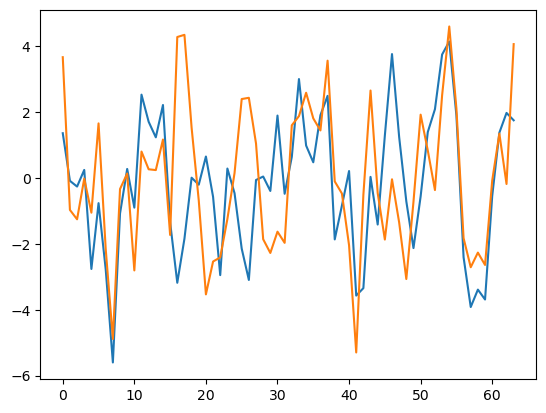

In [7]:
import matplotlib.pyplot as plt

plt.plot(xhat.detach().cpu().numpy()[0,22])
plt.plot(x.detach().cpu().numpy()[0,22])
plt.show()

In [8]:
xx = xhat.detach().cpu().numpy()
fc = []

for i in range(len(xx)):
    fc.append(np.corrcoef(xx[i]))

fc = np.stack(fc)

In [9]:
xxx = x.detach().cpu().numpy()
fc2 = []

for i in range(len(xxx)):
    fc2.append(np.corrcoef(xxx[i]))

fc2 = np.stack(fc2)

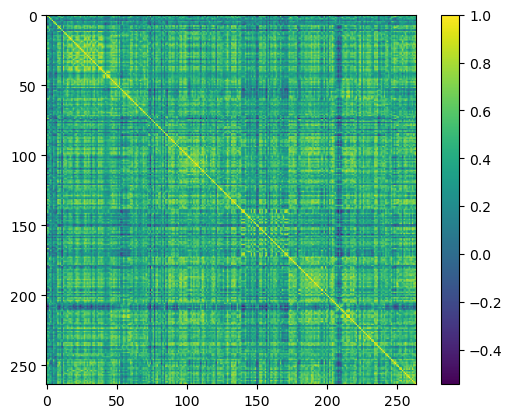

In [13]:
plt.imshow(fc2[19])
plt.colorbar()
plt.show()